
# 03 - Strategy Design
This notebook defines the trading signals for the mean-reversion strategy using the spread computed earlier.


In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:

# Load spread.csv as a Series
spread_df = pd.read_csv("../data/processed/spread.csv", index_col=0, parse_dates=True)
spread = spread_df.iloc[:, 0]  # take the first column as Series





In [3]:
window_z = 60  # or same window as your spread beta
spread_mean = spread.rolling(window=window_z).mean()
spread_std = spread.rolling(window=window_z).std()
z = (spread - spread_mean) / spread_std

# Drop initial NaNs and align spread
z = z.dropna()
spread = spread[z.index]


In [4]:
def sharpe_ratio(returns, freq=252):
    return (returns.mean() / returns.std()) * np.sqrt(freq)


In [5]:
import pandas as pd
import numpy as np

# Assume `spread` and `z` are already computed from your previous notebook/code

# Define grid
entry_grid = [1.0, 1.2, 1.5]
exit_grid = [0.2, 0.5, 0.8]
vol_grid = [0.005, 0.01, 0.02]  # target volatility

max_leverage = 10  # cap for position sizing
tc = 0.0005        # transaction cost

results = []




for entry_z in entry_grid:
    for exit_z in exit_grid:
        for target_vol in vol_grid:

            # Generate signals
            signals = pd.DataFrame(index=spread.index)
            signals['position'] = 0
            signals.loc[z > entry_z, 'position'] = -1
            signals.loc[z < -entry_z, 'position'] = 1
            signals['position'] = np.where(abs(z) < exit_z, 0, signals['position'])
            signals['position'] = signals['position'].ffill().fillna(0)

            # Volatility-adjusted position
            spread_std = spread.rolling(window=20).std()
            signals['position'] = signals['position'] * (target_vol / spread_std)
            signals['position'] = signals['position'].clip(-max_leverage, max_leverage)
            signals['position'] = signals['position'].fillna(0)

            # PnL calculation
            spread_ret = spread.diff()
            signals['pnl'] = signals['position'].shift(1) * spread_ret
            signals['trade'] = signals['position'].diff().abs()
            signals['pnl_tc'] = signals['pnl'] - 2 * signals['trade'] * tc

            # Performance metrics
            equity = signals['pnl_tc'].cumsum()


            sharpe = sharpe_ratio(signals['pnl_tc'].dropna())
            
            max_dd = (equity.cummax() - equity).max()
            num_trades = signals['trade'].sum()

            results.append({
                'entry_z': entry_z,
                'exit_z': exit_z,
                'target_vol': target_vol,
                'sharpe': sharpe,
                'max_drawdown': max_dd,
                'trades': num_trades
            })




In [6]:
# Convert to DataFrame and sort by Sharpe
grid_results = pd.DataFrame(results)
grid_results = grid_results.sort_values(by='sharpe', ascending=False).reset_index(drop=True)

# Show top 5 combinations
print(grid_results.head())

   entry_z  exit_z  target_vol    sharpe  max_drawdown     trades
0      1.0     0.2       0.005  2.486444      0.023838  10.339264
1      1.0     0.2       0.010  2.486444      0.047677  20.678528
2      1.0     0.2       0.020  2.486444      0.095354  41.357056
3      1.0     0.5       0.005  2.486444      0.023838  10.339264
4      1.0     0.5       0.010  2.486444      0.047677  20.678528


In [7]:
# Find the best row (highest Sharpe)
best_idx = grid_results['sharpe'].idxmax()
best_params = grid_results.loc[best_idx]

In [8]:
# Regenerate signals using the best parameters
entry_z = best_params['entry_z']
exit_z = best_params['exit_z']
target_vol = best_params['target_vol']

signals = pd.DataFrame(index=spread.index)
signals['position'] = 0
signals.loc[z > entry_z, 'position'] = -1
signals.loc[z < -entry_z, 'position'] = 1
signals['position'] = np.where(abs(z) < exit_z, 0, signals['position'])
signals['position'] = signals['position'].ffill().fillna(0)

spread_std = spread.rolling(window=20).std()
signals['position'] = signals['position'] * (target_vol / spread_std)
signals['position'] = signals['position'].clip(-max_leverage, max_leverage)
signals['position'] = signals['position'].fillna(0)

spread_ret = spread.diff()
signals['pnl'] = signals['position'].shift(1) * spread_ret
signals['trade'] = signals['position'].diff().abs()
signals['pnl_tc'] = signals['pnl'] - 2 * signals['trade'] * tc

# Save the final signals
signals.to_csv("../data/processed/signals.csv")

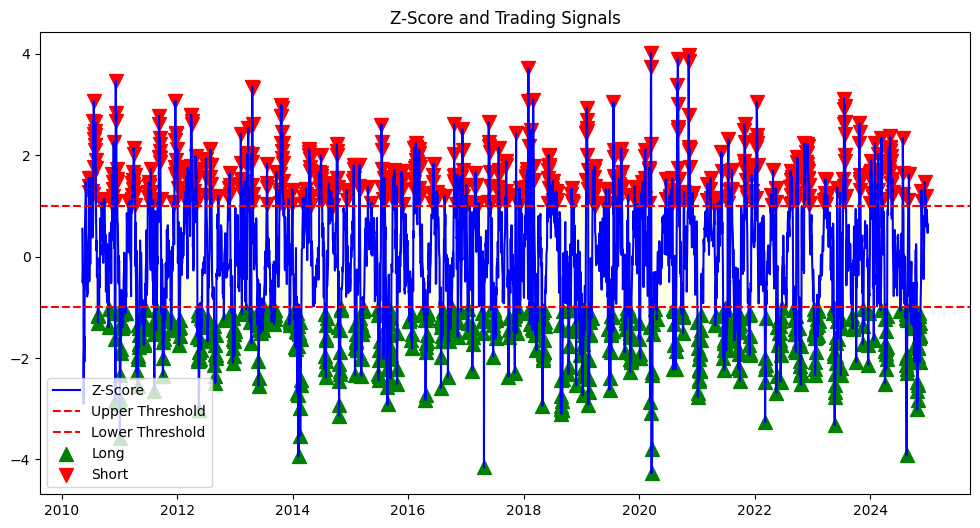

In [9]:
# Plot z-score and signals
plt.figure(figsize=(12,6))
plt.plot(z, label='Z-Score', color='blue')
plt.axhline(entry_z, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(-entry_z, color='r', linestyle='--', label='Lower Threshold')
plt.fill_between(z.index, entry_z, -entry_z, color='yellow', alpha=0.1)

# highlight positions
long_signals = signals['position'] > 0
short_signals = signals['position'] < 0
plt.scatter(z.index[long_signals], z[long_signals], marker='^', color='green', label='Long', s=100)
plt.scatter(z.index[short_signals], z[short_signals], marker='v', color='red', label='Short', s=100)

plt.title("Z-Score and Trading Signals")
plt.savefig("../results/tradin_signals.png")
plt.legend()
plt.show()